# MMM Toy Data Set: Two Variables - Balanced Spend - 2x Effect Ratio - Diminishing Returns

* Create a toy data set to explore relationships in Robyn
* Data set should include pre-Robyn window period to avoid cold start and take advantage of how Robyn uses data outside the window to estimate carryover marketing effects going into the first window day.
* Balanced spend: we are spending about the same amount on each channel
* Effect ratio: we know that one variable is more effective than the other (ground truth)
* Diminishing return: FB impact on bookings represents diminishing return relationship

Diminishing return formulas discussed here: https://gamedev.stackexchange.com/questions/89723/how-can-i-come-up-with-a-simple-diminishing-return-equation.  In effect the following equation is used where SCALE provides overall scale and POW controls how returns are diminished.
* =(POWER(FB_Spend+1,1-POW)-1)/(1-POW)*SCALE

In [1]:
import os
import sys
import pandas as pd
import numpy as np

In [2]:
np.random.seed(43)

bookings_columns = ['bookings_noiseless', 'bookings_noisy', 'bookings_noisy_context']

#
# data set has no lag effect from media at all here
#
for stderr in [600000]:
    print(f'Creating data set with stderr {stderr}')
    df = pd.DataFrame({'date':pd.date_range(start='2015-01-01', end='2021-12-31')})

    # marketing effort
    #
    # random tv marketing from 0 to 10000 each period
    # marketing has a $0 floor on TV spend
    df['tv'] = np.random.randint(0, 10000, size=len(df))
    
    # random fb spend, minimum threshold fb_daily_min each period
    # Marketing has both a non-zero floor and a ceiling on how much to sepend on FB
    fb_daily_min = 2500
    df['fb'] = np.random.randint(0, 5000, size=len(df)) + fb_daily_min
    
    # context variables for testing 
    df['context_0_center'] = np.random.normal( size=len(df))
    df['context_100_center'] = 100 + df.context_0_center
    
    
    fixed_bookings = 10000000
    tv_scale = 200
    context_scale = 800000
    
    #
    # But bookings are still driven by a fixed amount (call that business momentum) plus an effect which is linear in TV and FB
    #
    pow = 0.7    # controls diminishing slope
    neg_pow = 1 - pow
    fb_scale = 25500  # produce result with same order of magnitude as TV
    df['fb_contribution'] = (fb_scale * ((df.fb+1).pow(neg_pow)-1)/neg_pow).astype('int64')
    df['tv_contribution'] = df.tv * tv_scale
    df['bookings_noiseless'] = fixed_bookings + df.tv_contribution + df.fb_contribution
    df['bookings_noisy'] = df.bookings_noiseless + np.random.normal(loc=0, scale=stderr, size=len(df)) 
    
    # we use this whether predicting with context_0_center or context_100_center.  Those are two different forms of describing the same context
    df['bookings_noisy_context'] = df.bookings_noisy + df.context_0_center * context_scale
    
    for i in bookings_columns:
        print(f'Checking {i} for negative values')
        assert len(df[df[i]<0]) == 0, f'{i} has negative values which is not permitted'
    
    df.to_csv(os.path.join('data', f'robyn_toy_data_2paidvar_bal_eff2ratio_dimret_{stderr}err.csv'), index=False)


Creating data set with stderr 600000
Checking bookings_noiseless for negative values
Checking bookings_noisy for negative values
Checking bookings_noisy_context for negative values


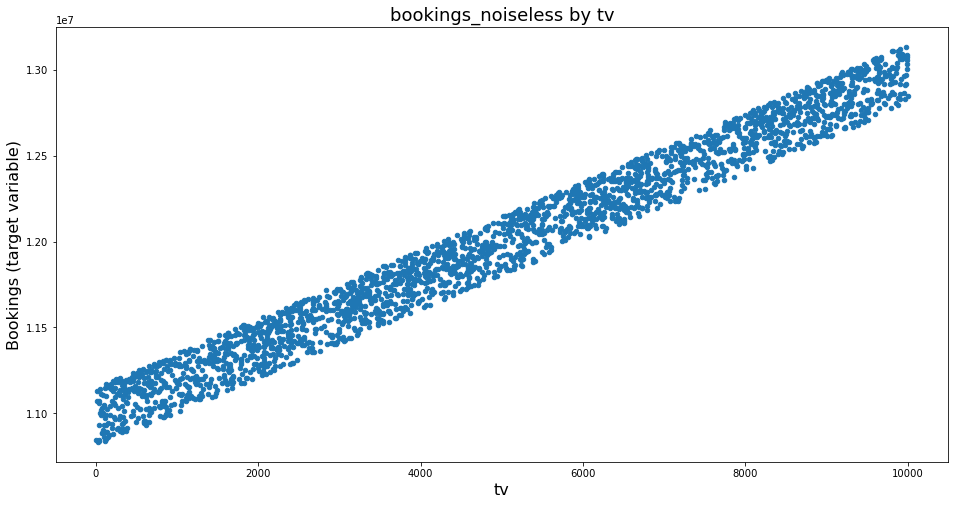

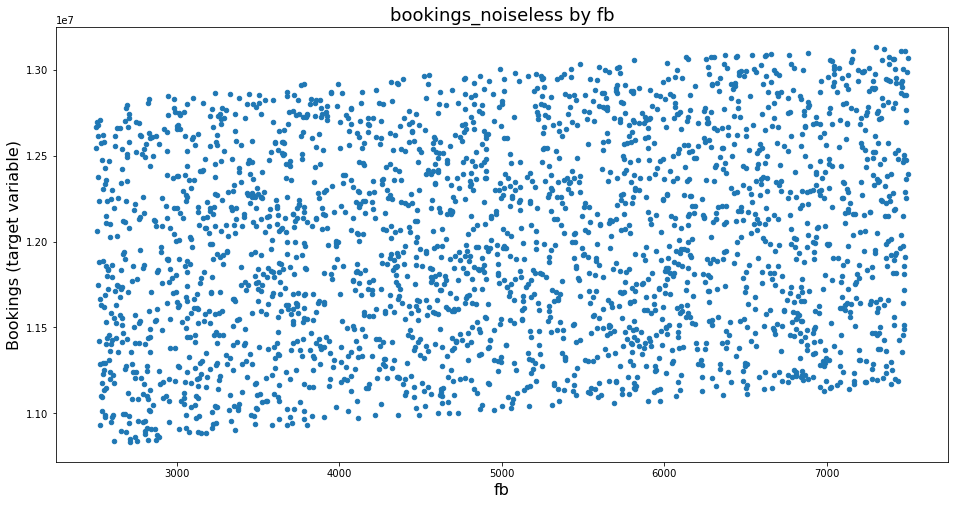

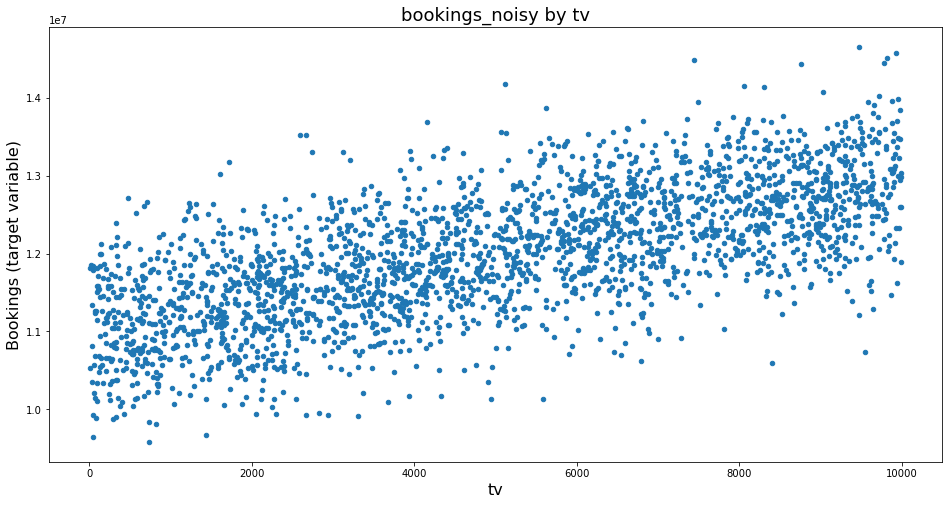

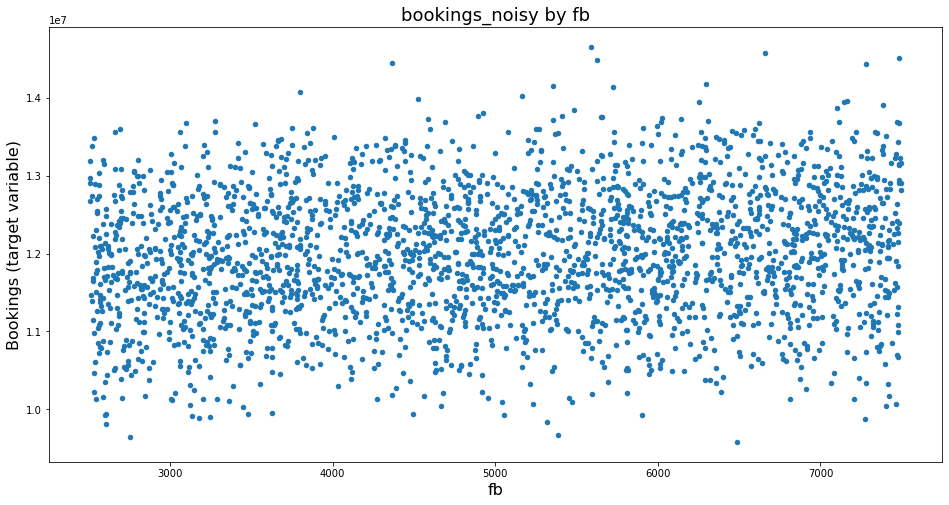

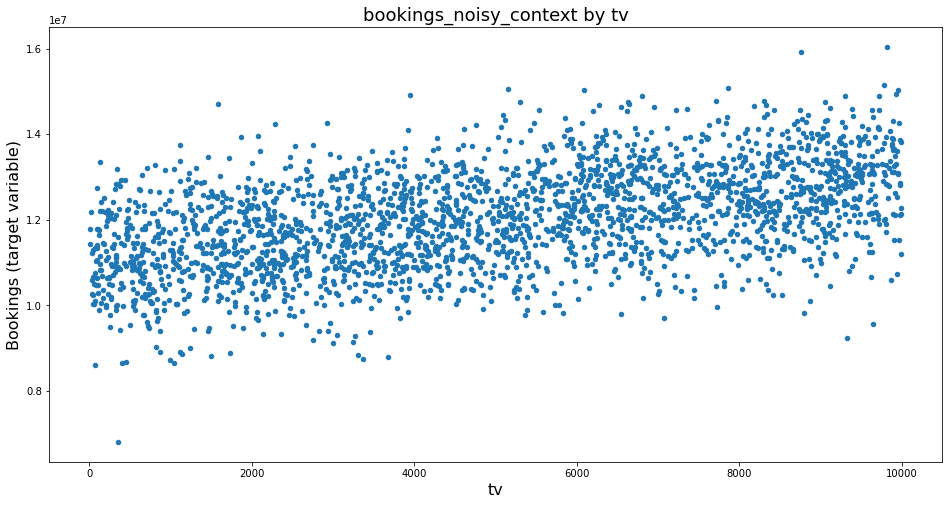

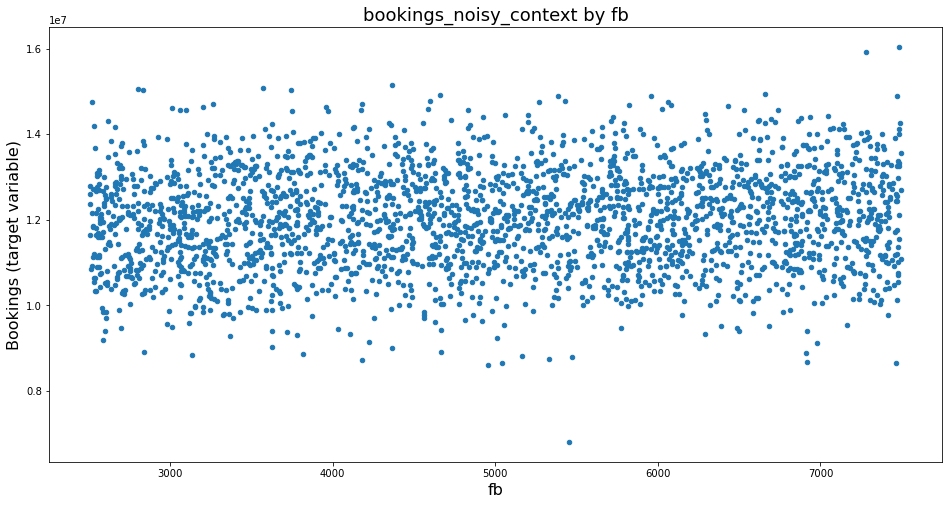

In [3]:
import matplotlib.pyplot as plt

for i in bookings_columns:
    for ivar in ['tv', 'fb']:
        ax = df.plot.scatter(y=i, x=ivar, figsize=(16,8))
        ax.set_title(f'{i} by {ivar}', fontsize=18)
        ax.set_ylabel('Bookings (target variable)', fontsize=16)
        ax.set_xlabel(ivar, fontsize=16)
        plt.show()

In [4]:
for i in bookings_columns:
    print(f'{i}: mean {df[i].mean():.0f} and stddev {df[i].std():.0f}')

bookings_noiseless: mean 11993263 and stddev 582568
bookings_noisy: mean 11992225 and stddev 827195
bookings_noisy_context: mean 12007357 and stddev 1144719


In [5]:
for i in ['fb', 'tv']:
    print(f'{i}: mean {df[i].mean():.0f} and stddev {df[i].std():.0f}')

fb: mean 4996 and stddev 1459
tv: mean 4973 and stddev 2858


## Checking the correct answer in Robyn for 2021 Window

In [6]:
df2021 = df[df['date'] >= pd.to_datetime('2021/01/01', format='%Y/%m/%d')]
len(df2021)

365

In [7]:
df2021.fb_contribution.sum()

362512495

In [8]:
df2021.tv_contribution.sum()

362187000

In [9]:
df2021.fb_contribution.sum() / (df2021.tv_contribution.sum()+df2021.fb_contribution.sum())

0.5002245723932787

### Note: The FB spend varies between a min and max, but should still be distinguishable by Robyn

In [10]:
df2021.bookings_noiseless.sum()

4374699495

In [11]:
# prove the math that we assume takes place here
df2021.bookings_noiseless.sum() - df2021.fb_contribution.sum() - df2021.tv_contribution.sum() - len(df2021) * fixed_bookings

0

## Spend Proportion in this data set

* Note: this data set has spend portion very different from impact portion
* So robyn's minimization of decomp.RSSD will balance against NRMSE

In [12]:
aggs = {
    'fb': 'sum',
    'tv': 'sum'
}
spend_portion = df2021.agg(aggs).reset_index()
spend_portion.rename(columns={'index': 'spend_type', 0: 'spend_amt'}, inplace=True)
spend_portion['percent_of_spend'] = (spend_portion['spend_amt'] / spend_portion['spend_amt'].sum()) * 100
spend_portion

,spend_type,spend_amt,percent_of_spend
0,fb,1797576,49.814896
1,tv,1810935,50.185104


In [13]:
df2021.fb.min()

2514

In [14]:
df2021.fb.max()

7488

In [15]:
df2021.tv.min()

16

In [16]:
df2021.tv.max()

9964

In [17]:
df2021.head(5)

,date,tv,fb,context_0_center,context_100_center,fb_contribution,tv_contribution,bookings_noiseless,bookings_noisy,bookings_noisy_context
2192,2021-01-01,2078,3016,0.862626,100.862626,855354,415600,11270954,1.157571e+07,1.226581e+07
2193,2021-01-02,9107,4615,1.391517,101.391517,983313,1821400,12804713,1.221213e+07,1.332535e+07
2194,2021-01-03,7741,2564,-0.039573,99.960427,810664,1548200,12358864,1.287627e+07,1.284461e+07
2195,2021-01-04,8972,4040,1.584725,101.584725,941515,1794400,12735915,1.273870e+07,1.400648e+07
2196,2021-01-05,8360,5526,1.386800,101.386800,1042627,1672000,12714627,1.228085e+07,1.339029e+07


In [18]:
df2021[df2021.date=='2021-07-01']

,date,tv,fb,context_0_center,context_100_center,fb_contribution,tv_contribution,bookings_noiseless,bookings_noisy,bookings_noisy_context
2373,2021-07-01,5698,7482,-1.056198,98.943802,1149928,1139600,12289528,1.238754e+07,1.154258e+07


In [19]:
df2021.fb_contribution.sum()

362512495

In [20]:
df2021.tv_contribution.sum()

362187000

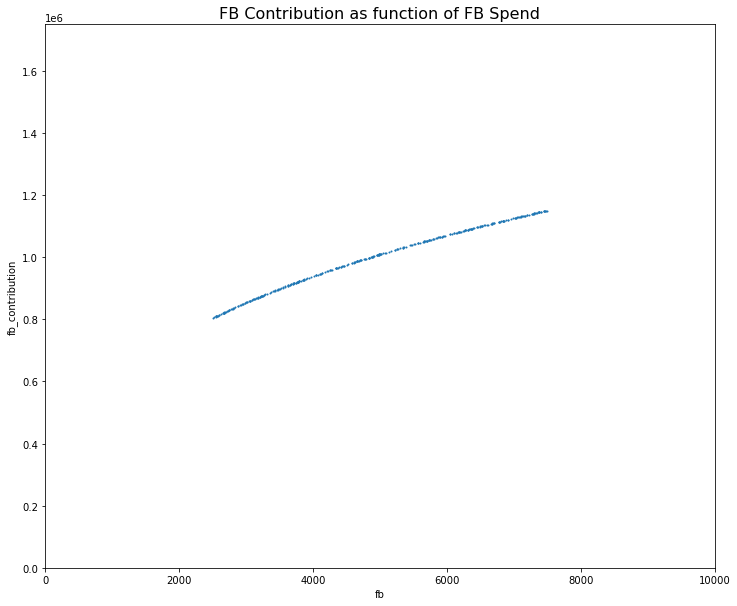

In [21]:
ax=df2021.plot.scatter(y='fb_contribution', x='fb', s=1, figsize=(12, 10))
_=ax.set_title('FB Contribution as function of FB Spend', fontsize=16)
_=ax.set_ylim(0, 1750000)
_=ax.set_xlim(0, 10000)